In this notebook we show how to implement a local threshold:

In [1]:
import torch
from flytracker import run

from flytracker.utils.param_helpers import load_frame, test_mask, test_threshold
from skimage.filters import threshold_local

import matplotlib.pyplot as plt

In [4]:
# Location of movie
movie_path = "../data/experiments/bruno/videos/seq_1.mp4"
image = load_frame(movie_path, frame=100, color=False)

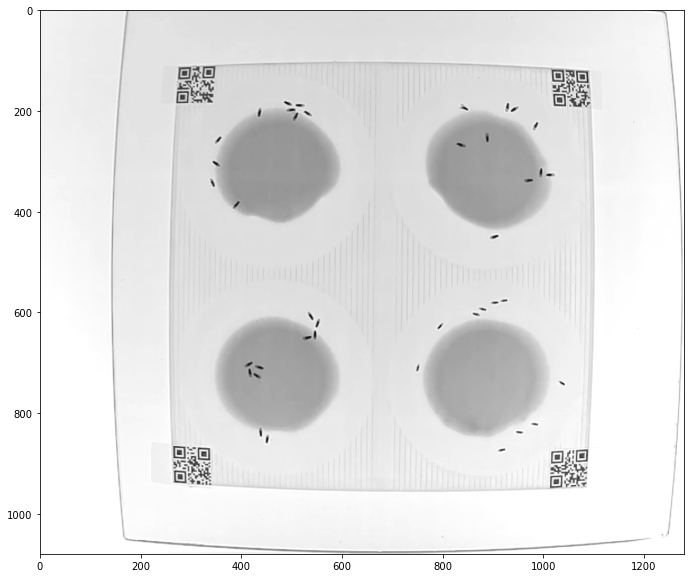

In [5]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')

In [6]:
mask = torch.ones((1080, 1280), dtype=bool)
mask[:130, :] = 0
mask[-160:, :] = 0
mask[:, :270] = 0
mask[:, -205:] = 0

mask[:190, :350] = 0
mask[:195, -270:] = 0
mask[-220:, :340] = 0
mask[870:, 1010:] = 0

masked_image = test_mask(image, mask)

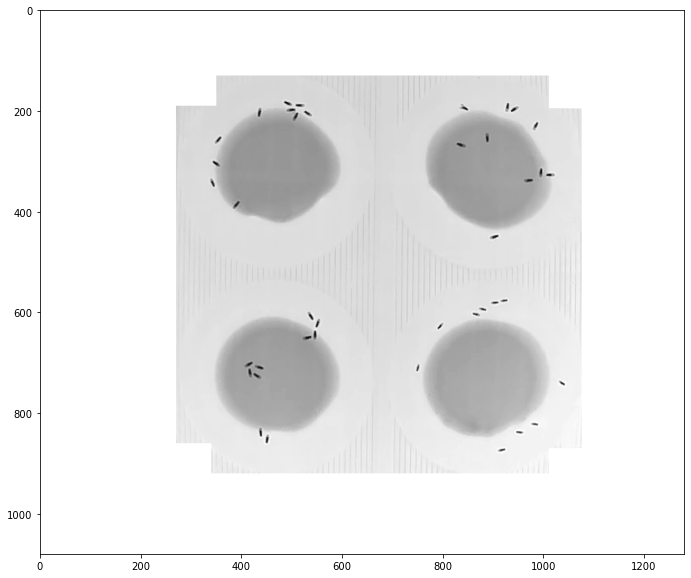

In [7]:
plt.figure(figsize=(15, 10))
plt.imshow(masked_image, cmap='gray')

Now we're going to build a local threshold. The idea is that flies are fairly sparse (they make up a small part of all the pixels), and that we can get the local lighting / background by using a big enough median filter. Everything more than 30 away from the local lighting is a fly. Since lighting remains constant, we only need to do this once.

You can probably do better filters with some tuning and thinking - the goal here is to show that you can use whatever you want as long as the arrays match shape:

In [8]:
def local_threshold(image, mask, threshold=30, block_size=31):
    background = threshold_local(image, block_size=block_size, method='median', )
    # we apply the mask after the background to avoid annoying edge effects
    background = test_mask(torch.tensor(background, dtype=torch.uint8), mask)
    return background - threshold

In [10]:
local_threshold = local_threshold(image, mask, 30, 31) # feed in unmasked image!
global_threshold = 120

In [14]:
print(local_threshold.shape, image.shape)

torch.Size([1080, 1280]) torch.Size([1080, 1280])


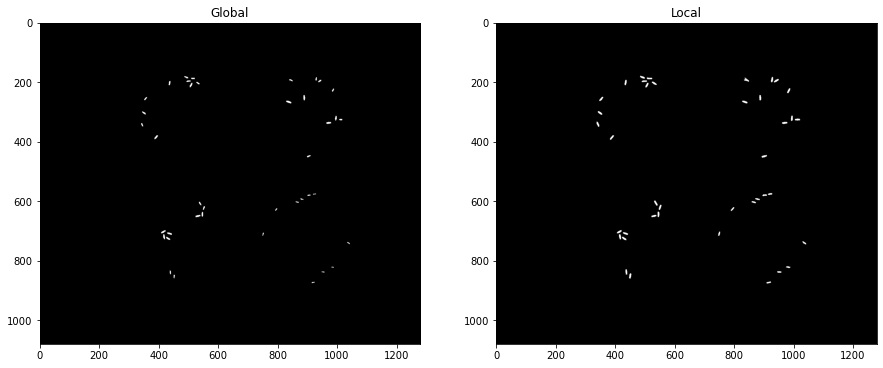

In [12]:
plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.title("Global")
plt.imshow(masked_image < global_threshold, cmap='gray')

plt.subplot(122)
plt.title("Local")
plt.imshow(masked_image < local_threshold, cmap='gray')

We see the flies being much bigger :) Lets run the global threshold for reference:

In [15]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=True,
    parallel=False,
    n_ini=100,
    n_frames=1000,
    threshold=global_threshold,
)

Done with frame 0
Done with frame 1000
CPU times: user 1min 9s, sys: 307 ms, total: 1min 9s
Wall time: 4.8 s


You can simply give the array as well:

In [16]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=True,
    parallel=False,
    n_ini=100,
    n_frames=1000,
    threshold=local_threshold,
)

/home/gert-jan/Documents/flyTracker/src/flytracker/tracker.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold).to(device, non_blocking=True),


Done with frame 0
Done with frame 1000
CPU times: user 1min 11s, sys: 440 ms, total: 1min 12s
Wall time: 4.73 s


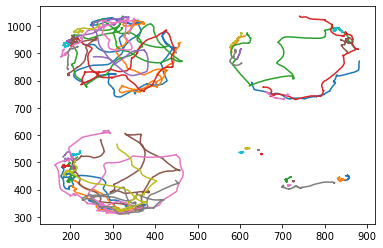

In [18]:
for ID in df.ID.unique():
    plt.plot(df.query(f"ID=={ID}")["x"], df.query(f"ID=={ID}")["y"])